# A little demonstration of how to play with data using Python notebooks


We're going to use a bunch of libraries which will make getting stuff done so much easier.

I'm googling for the library documentation as I go, I suggest you do likewise.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def whitespaces(x):
  return x.replace('\n', ' ')

First, we'll use Pandas to read the Excel sheet for national automobile roadworthiness statistics, and make sure the data is in the correct format.

Where it says `category`, that means that all of the cells in that column contain one of the same handful of values, such as 'Renkaat ja vanteet', so instead of storing a redundant copy of that string for each row, we're only storing each value once, and Pandas is referring back to that unique copy.

Where it says `whitespaces`, that means that the values in the Excel sheet contain '\n' newlines, which our custom converter translates into a space.

We actually manually opened the Excel first in OpenOffice, to figure out the `skiprows` and `skipfooter` values. You could automate that somehow, but why bother.

In [3]:
xlsx_2018 = 'https://www.traficom.fi/sites/default/files/media/file/Henkil%C3%B6autojen-m%C3%A4%C3%A4r%C3%A4aikaiskatsastusten-vuositilasto-2018.xlsx'

cars_2018 = pd.read_excel(xlsx_2018,
                          skiprows=6, skipfooter=429,
                          names=['car_year', 'make', 'model',
                                 'n', 'failed', 'driven_avg', 'driven_med',
                                 'cause_1', 'cause_2', 'cause_3'],
                          dtype={
                              'car_year': np.int16,
                              'make': 'category',
                              'model': str,
                              'n': np.int32,
                              'failed': np.float32,
                              'driven_avg': np.int32,
                              'driven_med': np.int32
                              },
                          converters={
                              'cause_1': whitespaces,
                              'cause_2': whitespaces,
                              'cause_3': whitespaces
                              }
                          )

#cars_2018 = cars_2018.convert_dtypes()

cars_2018['model'] = cars_2018['model'].astype('category')
cars_2018['cause_1'] = cars_2018['cause_1'].astype('category')
cars_2018['cause_2'] = cars_2018['cause_2'].astype('category')
cars_2018['cause_3'] = cars_2018['cause_3'].astype('category')

cars_2018 = cars_2018.loc[cars_2018['model'] != 'Mallit yhteensä']

cars_2018['make_model'] = cars_2018['make'].str.cat(cars_2018['model'], sep=' ').astype('category')

cars_2018['car_age'] = 2018 - cars_2018['car_year']

https://www.geeksforgeeks.org/python-pandas-series-str-cat-to-concatenate-string/


We can take a look at a random sample of that data, and style our view to make sense of the numbers.

In [4]:
df = cars_2018.sample(10)

(df.style
   .hide_index()
   .format({'failed': '{:.2f}'})
   .background_gradient(cmap='Oranges', low=-.2, high=.3, subset=['failed'])
   .background_gradient(cmap='Oranges', low=-.2, high=.5, subset=['driven_avg', 'driven_med']))

car_year,make,model,n,failed,driven_avg,driven_med,cause_1,cause_2,cause_3,make_model,car_age
2005,Mitsubishi,COLT,351,20.51,147000,144000,Jousitus ja iskunvaimennus,Seisontajarrun dynamometritesti,Sisäinen valvontajärjestelmä (OBD),Mitsubishi COLT,13
2015,Toyota,COROLLA,663,0.90,38000,35000,nan,nan,nan,Toyota COROLLA,3
2005,Volvo,XC90,685,34.16,280000,269000,Seisontajarrun dynamometritesti,Jousitus ja iskunvaimennus,Etuakselisto,Volvo XC90,13
2003,Ford,FOCUS C-MAX,188,41.49,244000,232000,Etuakselisto,Jousitus ja iskunvaimennus,Ohjausnivelet ja -tangot,Ford FOCUS C-MAX,15
2015,Volkswagen,TOURAN,409,3.67,79000,67000,nan,nan,nan,Volkswagen TOURAN,3
2003,Honda,CIVIC,1170,25.13,200000,202000,Etuakselisto,Seisontajarrun dynamometritesti,Käyttöjarru,Honda CIVIC,15
2005,Toyota,YARIS VERSO,379,20.58,191000,176000,Käyttöjarru,Jousitus ja iskunvaimennus,Käyttöjarrun dynamometritesti,Toyota YARIS VERSO,13
2011,Ford,TRANSIT,126,26.98,274000,219000,Etuakselisto,Käyttöjarru,nan,Ford TRANSIT,7
2009,Honda,ACCORD,863,14.14,194000,189000,Etuakselisto,Käyttöjarru,Renkaat ja vanteet,Honda ACCORD,9
2011,Audi,A5,604,3.97,140000,135000,nan,nan,nan,Audi A5,7


We can select a slice of the data which we might find interesting at a time, and use it as a basis for further operations.

In [5]:
#avensis = cars_2018.loc[(cars_2018['make'] == 'Toyota') & (cars_2018['model'] == 'AVENSIS')]
avensis = cars_2018.loc[cars_2018['make_model'] == 'Toyota AVENSIS']

avensis

,car_year,make,model,n,failed,driven_avg,driven_med,cause_1,cause_2,cause_3,make_model,car_age
127,2003,Toyota,AVENSIS,5708,21.180000,262000,252000,Seisontajarrun dynamometritesti,Sisäinen valvontajärjestelmä (OBD),Käyttöjarru,Toyota AVENSIS,15
295,2004,Toyota,AVENSIS,5140,19.260000,249000,240000,Sisäinen valvontajärjestelmä (OBD),Käyttöjarru,Seisontajarrun dynamometritesti,Toyota AVENSIS,14
476,2005,Toyota,AVENSIS,4947,18.620001,238000,226000,Etuakselisto,Käyttöjarru,Käyttöjarrun dynamometritesti,Toyota AVENSIS,13
662,2006,Toyota,AVENSIS,4999,15.980000,230000,215000,Etuakselisto,Seisontajarrun dynamometritesti,Käyttöjarru,Toyota AVENSIS,12
855,2007,Toyota,AVENSIS,3264,13.850000,219000,204000,Seisontajarrun dynamometritesti,Käyttöjarru,Etuakselisto,Toyota AVENSIS,11
1046,2008,Toyota,AVENSIS,3612,12.320000,211000,198000,Seisontajarrun dynamometritesti,Käyttöjarru,Käyttöjarrun dynamometritesti,Toyota AVENSIS,10
1215,2009,Toyota,AVENSIS,4975,7.420000,172000,163000,Taka-akselisto,Käyttöjarru,Käyttöjarrun dynamometritesti,Toyota AVENSIS,9
1395,2010,Toyota,AVENSIS,4723,5.990000,159000,148000,Taka-akselisto,Käyttöjarru,Käyttöjarrun dynamometritesti,Toyota AVENSIS,8
1580,2011,Toyota,AVENSIS,4476,4.560000,140000,129000,Taka-akselisto,NaN,NaN,Toyota AVENSIS,7
1762,2012,Toyota,AVENSIS,4179,3.300000,122000,113000,Renkaat ja vanteet,NaN,NaN,Toyota AVENSIS,6


Looks like Toyota Avensis is a very reliable car (although it would be nice to have data on EUR spent on maintenance as well) but it's about half as popular in 2015 than it was in 2003, even without taking into account the older cars, which have been removed from the population over the years.

If I had to guess, I'd say that at very low failure percentages, like <5%, `cause_1` is likely not representative of anything, but basically just a random pick out of an equally probable list of very unlikely failure modes.

In [6]:
hardy = cars_2018.query('driven_avg > 200000 and failed < 20 and n > 1000')

hardy

,car_year,make,model,n,failed,driven_avg,driven_med,cause_1,cause_2,cause_3,make_model,car_age
130,2003,Toyota,COROLLA,8920,18.549999,221000,216000,Seisontajarrun dynamometritesti,Käyttöjarrun dynamometritesti,Käyttöjarru,Toyota COROLLA,15
295,2004,Toyota,AVENSIS,5140,19.260000,249000,240000,Sisäinen valvontajärjestelmä (OBD),Käyttöjarru,Seisontajarrun dynamometritesti,Toyota AVENSIS,14
298,2004,Toyota,COROLLA,8734,16.580000,206000,200000,Käyttöjarrun dynamometritesti,Seisontajarrun dynamometritesti,Käyttöjarru,Toyota COROLLA,14
299,2004,Toyota,COROLLA\nVERSO,1660,18.610001,244000,238000,Seisontajarrun dynamometritesti,Käyttöjarru,Käyttöjarrun dynamometritesti,Toyota COROLLA\nVERSO,14
329,2005,Audi,A6,1996,19.290001,285000,278000,Etuakselisto,Jousitus ja iskunvaimennus,Käyttöjarru,Audi A6,13
372,2005,Honda,CR-V,1708,17.680000,236000,226000,Käyttöjarru,Etuakselisto,Sisäinen valvontajärjestelmä (OBD),Honda CR-V,13
476,2005,Toyota,AVENSIS,4947,18.620001,238000,226000,Etuakselisto,Käyttöjarru,Käyttöjarrun dynamometritesti,Toyota AVENSIS,13
479,2005,Toyota,COROLLA\nVERSO,2007,15.500000,248000,236000,Käyttöjarru,Seisontajarrun dynamometritesti,Jousitus ja iskunvaimennus,Toyota COROLLA\nVERSO,13
509,2006,Audi,A6,2313,16.040001,260000,253000,Etuakselisto,Sisäinen valvontajärjestelmä (OBD),Käyttöjarru,Audi A6,12
558,2006,Honda,CR-V,1574,16.770000,238000,231000,Etuakselisto,Käyttöjarru,Sisäinen valvontajärjestelmä (OBD),Honda CR-V,12


# Let's look at the data

First, let's see how well failures correlate with driven kilometers over the whole car population.

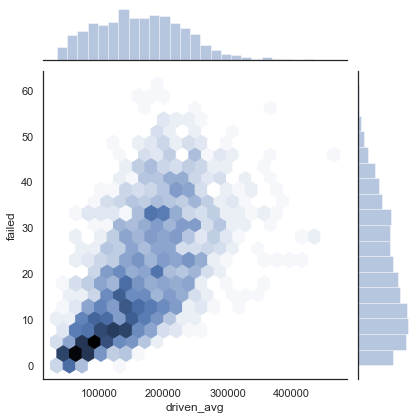

In [7]:
sns.set(style="darkgrid")

with sns.axes_style('white'):
    sns.jointplot("driven_avg", "failed", data=cars_2018, kind='hex')


While there is a correlation, we can also see that there's a large part of the population which has failure factors other than kilometers driven.

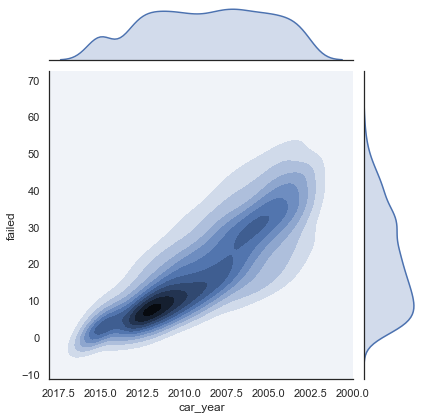

In [8]:
with sns.axes_style('white'):
    g = sns.jointplot("car_year", "failed", data=cars_2018, kind='kde')
    g.fig.axes[0].invert_xaxis()

plt.show()

Let's take a look at the reliability of a few interesting models.

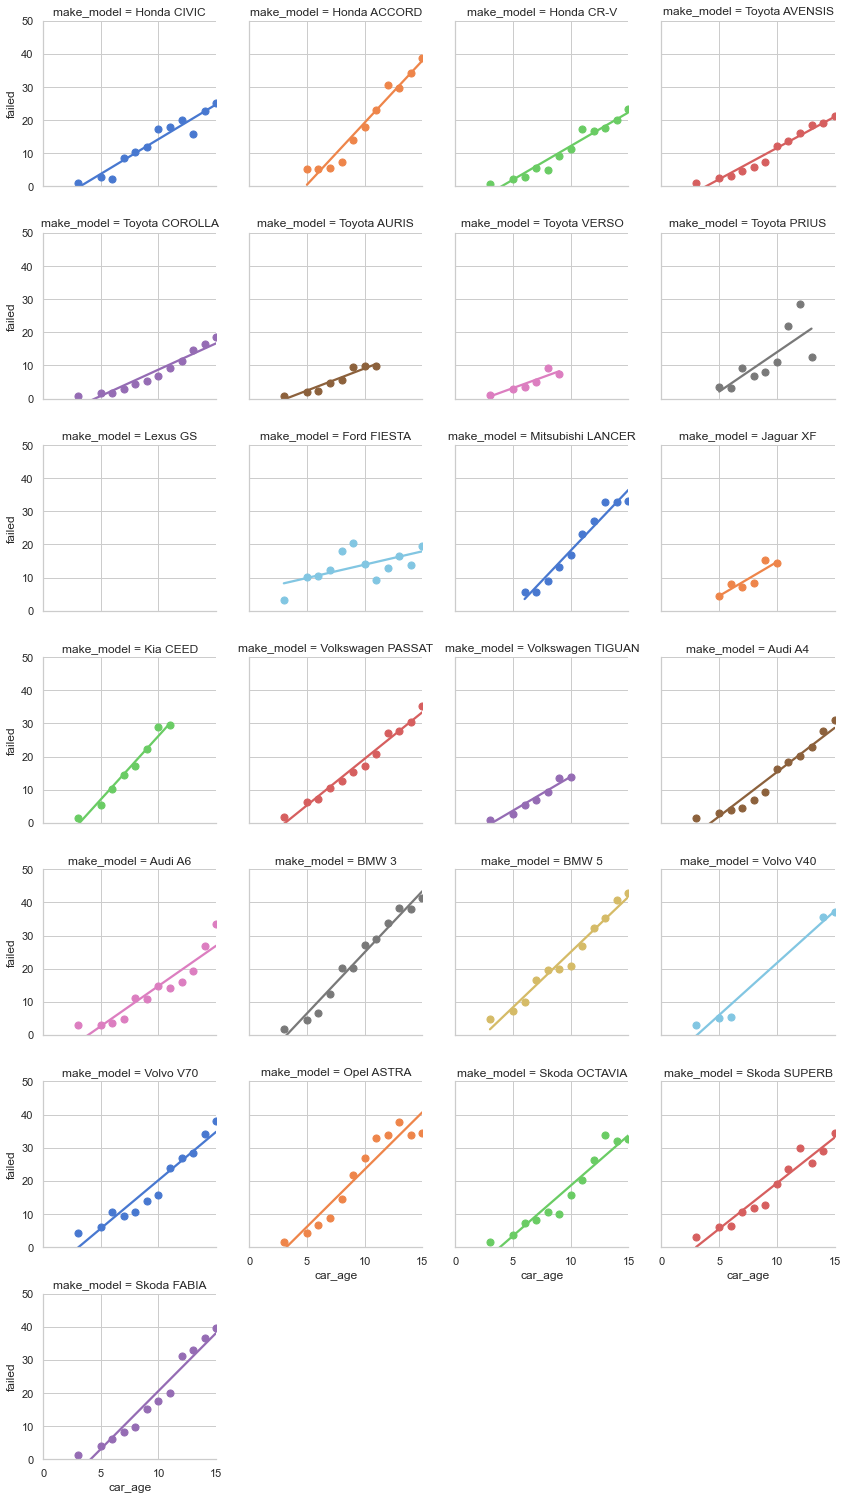

In [9]:
reliable_models = [
    'Honda CIVIC', 'Honda ACCORD', 'Honda CR-V',
    'Toyota AVENSIS', 'Toyota COROLLA', 'Toyota AURIS', 'Toyota VERSO',
    'Toyota PRIUS',
    'Lexus GS',
    'Ford FIESTA',
    'Mitsubishi LANCER',
    'Jaguar XF',
    'Kia CEED',
    'Volkswagen PASSAT', 'Volkswagen TIGUAN',
    'Audi A4', 'Audi A6',
    'BMW 3', 'BMW 5',
    'Volvo V40', 'Volvo V70',
    'Opel ASTRA',
    'Skoda OCTAVIA', 'Skoda SUPERB', 'Skoda FABIA'
]

cars = cars_2018[cars_2018['make_model'].isin(reliable_models)]

sns.set_style("whitegrid")

g = sns.lmplot(x="car_age", y="failed", col="make_model", hue="make_model", data=cars,
           col_order=reliable_models, hue_order=reliable_models,
           col_wrap=4, ci=None, palette="muted", height=3,
           fit_reg=True,
           scatter_kws={"s": 50, "alpha": 1})

g.axes[0].set_ylim(0, 50)
g.axes[0].set_xlim(0, 15)

plt.show()

Only 20% of 15 year old Toyota Avensis cars fail their check, and its dataset is so linear that one would suspect that part wear is what gets to Avensis in the end. Honda Civic is almost as good, but has more variance. One would suspect that Honda makes more changes of the less incremental nature to that model.

Now let's look at the model specific failure correlation with driven kilometers.

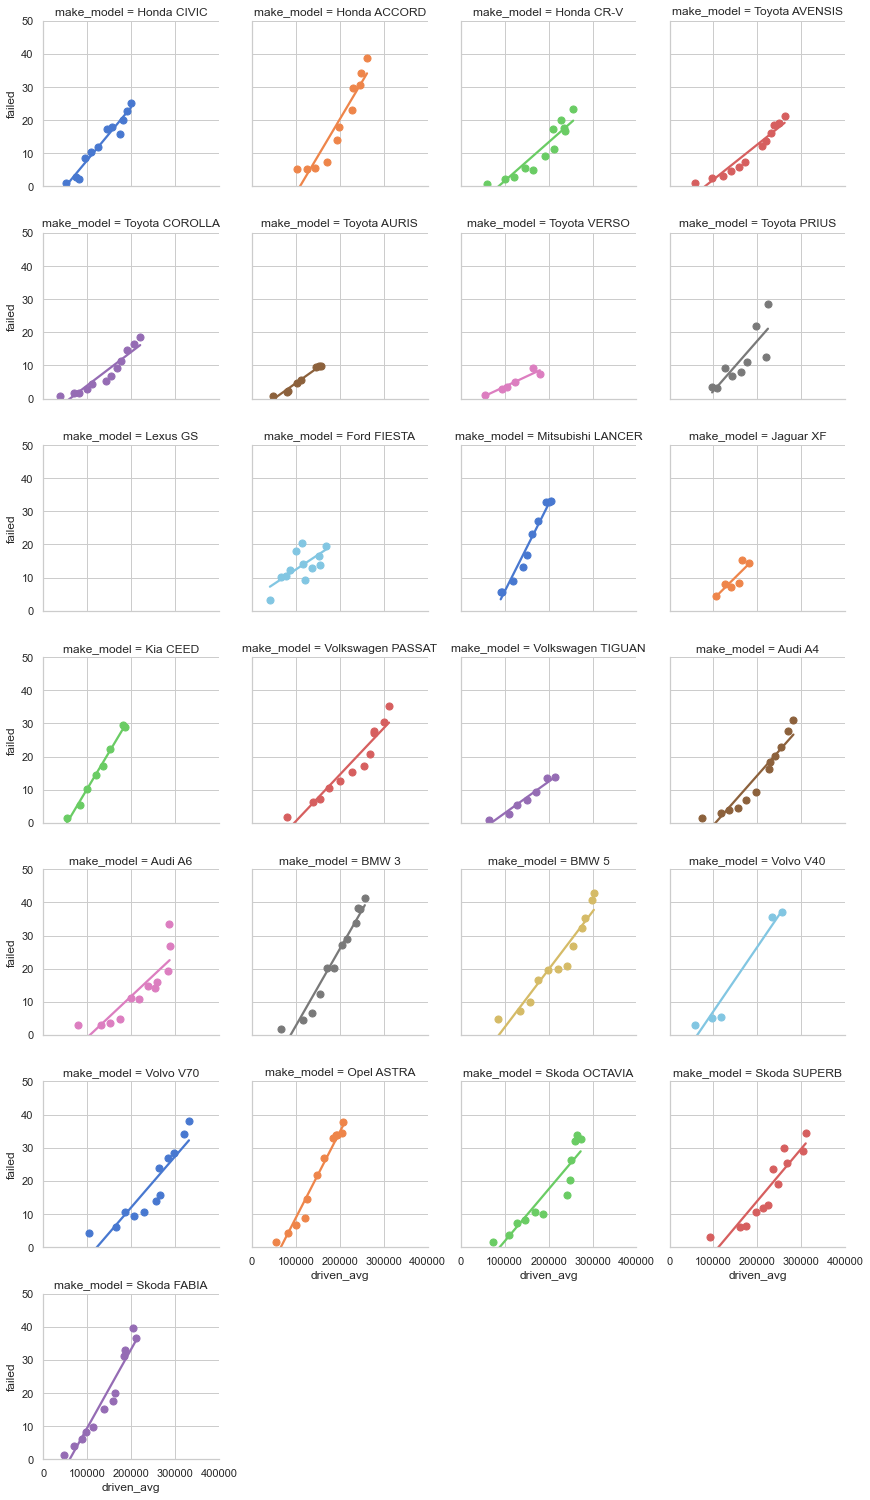

In [10]:
g = sns.lmplot(data=cars,
               x="driven_avg", y="failed", col="make_model", hue="make_model",
               col_order=reliable_models, hue_order=reliable_models,
               col_wrap=4, ci=None, palette="muted", height=3,
               fit_reg=True,
               scatter_kws={"s": 50, "alpha": 1})

g.axes[0].set_ylim(0, 50)
g.axes[0].set_xlim(0, 400000)

plt.show()

Here the weakness of the data leaves us hanging. We know that people drive Toyotas less per annum, but because the data cuts off at 15 years, we don't know what happens after 200,000 kilometers. It's completely credible that the Toyotas just keep going, but this data doesn't tell us that.

The BMWs, Volvos and Skodas do have that data available, because people seem to put a lot more kilometers on them.